In [9]:
%load_ext autoreload

In [10]:
%autoreload

import sys
sys.path.append('..')

import torch
import torch.utils.data as D

import os
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import color.models as models
import color.models.model_utils as model_utils
import color.models.predict_color as predict_color_models
import color.data.dataset as color_dataset
import color.training as training
import color.utils.utils as utils

In [11]:
# Load a model from a directory
save_dir = '../trained_models/cnn-color-predictor_859522'
model_class, _ = models.get_model('predict_color_cnn')
seq_len_first=False
assert os.path.isdir(save_dir)

In [ ]:
# Load training params and losses
training_params = training.load_training_params(save_dir)
pprint.pprint(training_params)

In [13]:
# Re-create dataset
dataset = color_dataset.Dataset.load(save_dir)
print(dataset.params)
print('Dataset Size:', len(dataset))

Loading colors dataset
Loading embeddings
Padding embeddings for color names
Random partitions were not created
{'dataset': 'big', 'emb_len': 200, 'normalize_rgb': True, 'max_words': 3, 'pad_len': 3, 'add_stop_word': False, 'create_partitions': False, 'cv_split': 0.1, 'test_split': 0}
Dataset Size: 17945


In [14]:
# Load model params and weights
model_weights, model_params = model_utils.load_model_params(save_dir)
print(model_params)
print(len(model_weights))

{'name': 'cnn-color-predictor', 'emb_dim': 200, 'color_dim': 3, 'lr': 0.006, 'momentum': 0.85, 'weight_decay': 1e-05, 'lr_decay': (3, 0.96), 'max_words': 3, 'num_conv_layers': 3, 'conv_kernel_size': 5, 'conv_stride': 2, 'pool_kernel_size': 7, 'pool_stride': 1, 'num_linear_layers': 2, 'linear_size_reduce': 2}
12


In [16]:
# Initialize trained model
model = model_class(**model_params).double()
model.load_state_dict(model_weights)
print(model)
print('Trainable Params:', utils.get_trainable_params(model))

ColorPredictorCNNModel(
  (cnn1): Conv1d(3, 6, kernel_size=(5,), stride=(2,))
  (pool1): MaxPool1d(kernel_size=7, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv1d(6, 12, kernel_size=(5,), stride=(2,))
  (pool2): MaxPool1d(kernel_size=7, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv1d(12, 24, kernel_size=(5,), stride=(2,))
  (pool3): MaxPool1d(kernel_size=7, stride=1, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=264, out_features=132, bias=True)
  (linear2): Linear(in_features=132, out_features=66, bias=True)
  (final_linear): Linear(in_features=66, out_features=3, bias=True)
)
Trainable Params: 45891


In [17]:
# Convenience wrapper around the price colors function
predict_colors = lambda color_names: predict_color_models.predict_colors(
    model, dataset, color_names,
    seq_len_first=seq_len_first
)

In [18]:
def plot_expected_colors(color_names, color_rgb):
    '''Plot colors with their actual color names'''
    fig = plt.figure(figsize=(15, 2))
    ax = fig.add_subplot(111)
    total_width = 400
    total_height = 200
    col_width = total_width / len(color_names)
    for i, (cn, rgb) in enumerate(zip(color_names, color_rgb)):
        p = patches.Rectangle((col_width*i,0), total_width, total_height, color=rgb)
        ax.add_patch(p)
        ax.text(col_width*(i+0.25),total_height/2, cn)
    plt.xlim([0, total_width])
    plt.ylim([0, total_height])
    plt.xticks([])
    plt.yticks([])    

In [19]:
def plot_predicted_colors(color_names):
    '''Predict rgb values for a list of colors and plot them'''
    fig = plt.figure(figsize=(15, 2))
    ax = fig.add_subplot(111)
    total_width = 400
    total_height = 200
    col_width = total_width / len(color_names)
    for i, (cn, pred) in enumerate(zip(color_names, predict_colors(color_names))):
        p = patches.Rectangle((col_width*i,0), total_width, total_height, color=pred)
        ax.add_patch(p)
        ax.text(col_width*(i+0.25),total_height/2, cn)
    plt.xlim([0, total_width])
    plt.ylim([0, total_height])
    plt.xticks([])
    plt.yticks([])    

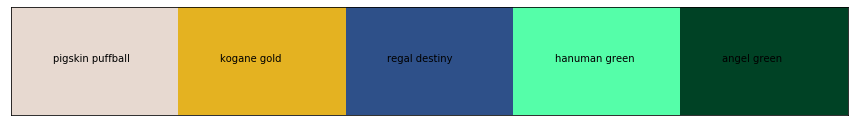

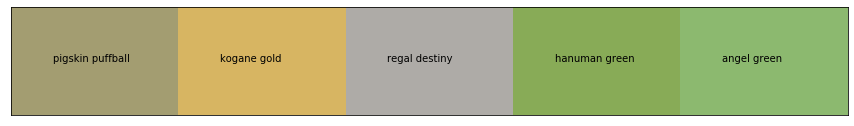

In [25]:
# Plot some training samples
select = 5
idx = np.arange(len(dataset.train_set))
np.random.shuffle(idx)
train_loader = iter(color_dataset.DataLoader(dataset.train_set, shuffle=True, seq_len_first=seq_len_first))
colors_selected = [(color_rgb, color_name) for color_rgb, _, color_name in [next(train_loader) for _ in range(select)]]
color_rgb_selected = list(map(lambda x: x[0].view(-1).tolist(), colors_selected))
color_names_selected = list(map(lambda x: x[1][0], colors_selected))
plot_expected_colors(color_names_selected, color_rgb_selected)
plot_predicted_colors(color_names_selected)

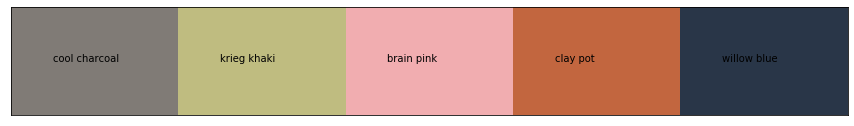

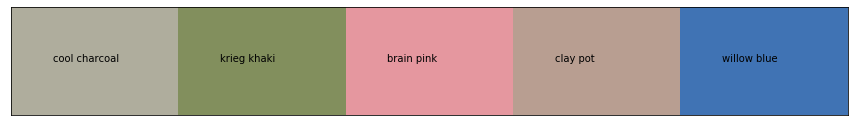

In [30]:
# Plot some CV samples
select = 5
idx = np.arange(len(dataset.cv_set))
np.random.shuffle(idx)
cv_loader = iter(color_dataset.DataLoader(dataset.cv_set, shuffle=True, seq_len_first=seq_len_first))
colors_selected = [(color_rgb, color_name) for color_rgb, _, color_name in [next(train_loader) for _ in range(select)]]
color_rgb_selected = list(map(lambda x: x[0].view(-1).tolist(), colors_selected))
color_names_selected = list(map(lambda x: x[1][0], colors_selected))
plot_expected_colors(color_names_selected, color_rgb_selected)
plot_predicted_colors(color_names_selected)

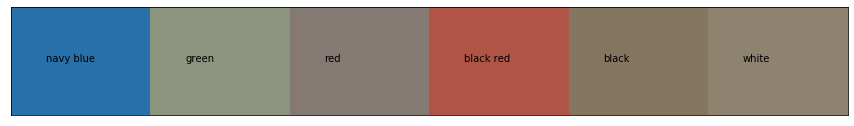

In [31]:
# Plot some more colors
more_color_names = ['navy blue', 'green', 'red', 'black red', 'black', 'white']
plot_predicted_colors(more_color_names)

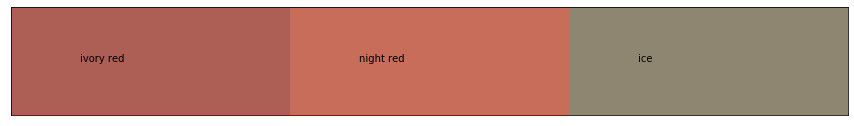

In [32]:
# Plot some more colors
more_color_names = ['ivory red', 'night red', 'ice']
plot_predicted_colors(more_color_names)